<a href="https://colab.research.google.com/github/MarcelDelhez/Albatross/blob/master/Efficient_CVar_Allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Management Tool.
This proof of concept aims to introduce the discussion about an interactive way to build portfolio's.

In [5]:
# @title Initialization
!pip install pandas numpy matplotlib yfinance PyPortfolioOpt
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from pypfopt import EfficientCVaR, EfficientCDaR, expected_returns, objective_functions
from pypfopt.exceptions import OptimizationError

from ipywidgets import widgets

## First step: chosing the building blocks.
Into this example, the building blocks are just shares and not building blocks as such.  It is for the ease of building a proof of concept as it eliminates the development related to building blocks management.

In [8]:
# @title Chosing building blocks.
# --- Here, the instruments present into the Kern.

tickers = ["XOM", "SHEL", "CRH", "LIN", "SGO.PA", "DG.PA", "SIE.DE", "EMR", "OTIS", "SBUX", "ADS.DE", "BKNG", "MBG.DE", "AMZN", "RI.PA", "OR.PA", "NSRGY", "PEP", "UCB.BR", "RHHBY", "UEEC", "JNJ", "BMY", "MDT", "AZN", "KBC.BR", "BNP.PA", "STAN.L", "JPM", "AXP", "AGS.BR", "MET", "ZURN.SW", "DB1.DE", "NXPI", "QCOM", "MSFT", "ADBE", "ORCL", "AAPL", "ASML", "META", "NFLX", "ELI.BR", "ENEL.MI"]
tickers.sort()

checkboxes = []
for item in tickers:
    checkbox = widgets.Checkbox(description=item + " - " + yf.Ticker(item).info['shortName'], value=True)
    checkboxes.append(checkbox)

widgets.VBox(checkboxes)

## Step 2: Retrieve expected returns.
Here as well, for the proof of concept, I made it easy into the sense I calculated the expected returns based on the mean historical returns during last two years.
Ideally, those expected returns must be provided by Investment Office and would never be showed to customers.  This step is only for illustrating the concept.

It is also at this step that the risk is estimated.
For that, we can use diverse risk metrics like Volatility, VaR, CVaR ... Here, I opted for the *Expected Shortfall* (CDaR).

[*********************100%***********************]  20 of 20 completed


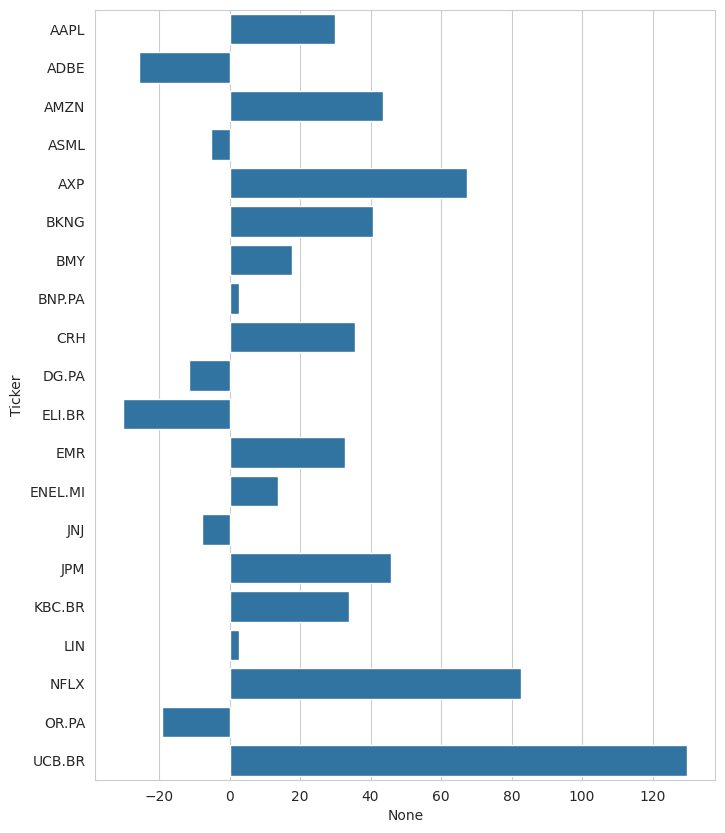

In [35]:
# @title Historical data to retrieve { run: "auto" }
HistData = "1y" # @param ["1y", "2y", "5y", "10y"]

selection = []
for i in range(0, len(checkboxes)):
    if checkboxes[i].value == True:
        selection.append(checkboxes[i].description.split(" ", 1)[0])
tickers = selection

ohlc = yf.download(tickers, period=HistData)
prices = ohlc["Close"]
prices = prices.ffill()

beta = 0.99
df = prices.resample("ME").first()
mu = expected_returns.mean_historical_return(df, frequency=12)
historical_rets = expected_returns.returns_from_prices(df).dropna()

# --- Si les expected returns sont donnés par IIO ---
#IIO_Ret = {'AMZN': .34, 'KO': .03, 'COST': .19, 'DPZ': -0.01, 'XOM': 0.21, 'TSLA': -0.10, 'MCD': .11, 'MSFT': .14, 'NAT': .27, 'SBUX': 0.01}
#mu = pd.Series(data=IIO_Ret, index=IIO_Ret.keys(), dtype="float64")
#mu.index.name = "Ticker"
mu=mu.sort_index()

plt.figure(figsize=(8,10))
sns.barplot(x=mu*100, y=mu.keys(), orient='h')
plt.show()

## Step 3: Select the maximum allocation percentage.
This represent the percentage of allocation that is allowed for the position that has the most weight into the portfolio.
How smaller this number how more diversificated the portfolio will be.
If set to 100%, the portfolio could be composed with just one building block.

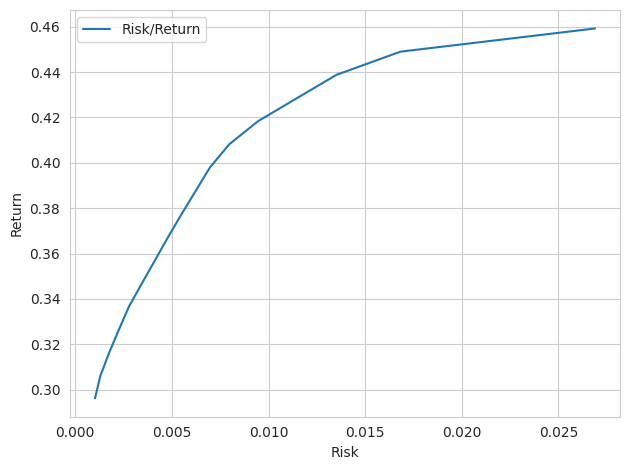

<Axes: xlabel='Risk', ylabel='Return'>

In [39]:
# @title A view on Risk / Reward { run: "auto" }
MaxPctAlloc = 8 # @param {type:"slider", min:3, max:100, step:1}

def _plot_ef_cdar(ef, ef_param, ef_param_range, ax, show_assets, show_tickers):
    """
    Helper function to plot the efficient frontier from an EfficientFrontier object
    """
    mus, sigmas = [], []

    # Create a portfolio for each value of ef_param_range
    for param_value in ef_param_range:
        try:
            if ef_param == "utility":
                ef.max_quadratic_utility(param_value)
            elif ef_param == "risk":
                ef.efficient_risk(param_value)
            elif ef_param == "return":
                ef.efficient_return(param_value)
            else:
                raise NotImplementedError(
                    "ef_param should be one of {'utility', 'risk', 'return'}"
                )
        except:
        # except exceptions.OptimizationError:
            continue
        #except ValueError:
        #    warnings.warn(
        #        "Could not construct portfolio for parameter value {:.3f}".format(
        #            param_value
        #        )
        #    )

        ret, sigma = ef.portfolio_performance()
        mus.append(ret)
        sigmas.append(sigma)

    ax.plot(sigmas, mus, label="Risk/Return")

    asset_mu = ef.expected_returns
    asset_sigma = np.sqrt(np.diag(ef.cov_matrix))
    if show_assets:
        ax.scatter(
            asset_sigma,
            asset_mu,
            s=30,
            color="k",
            label="assets",
        )
        if show_tickers:
            for i, label in enumerate(ef.tickers):
                ax.annotate(label, (asset_sigma[i], asset_mu[i]))
    return ax

def plot_ef_cdar(
    opt,
    ef_param="return",
    ef_param_range=None,
    points=100,
    ax=None,
    show_assets=True,
    show_tickers=False,
    **kwargs
):
    ax = ax or plt.gca()

    if ef_param_range is None:
        ef_param_range = _ef_default_returns_range(opt, points)
    ax = _plot_ef_cdar(
        opt,
        ef_param,
        ef_param_range,
        ax=ax,
        show_assets=show_assets,
        show_tickers=show_tickers,
    )

    ax.legend()
    ax.set_xlabel("Risk")
    ax.set_ylabel("Return")

    plt.tight_layout()
    plt.show()
    return ax

cv = EfficientCDaR(mu, historical_rets, beta=beta, weight_bounds=(0, MaxPctAlloc/100))

fig, ax = plt.subplots()
risk_range = np.linspace(0.00, 0.50, 50)
plot_ef_cdar(cv, ax=ax, ef_param="return", ef_param_range=risk_range, show_assets=False)

## Step 4: Customer select the accepted risk.
Based on the curve representing the return that can be expected when taking a given level of risk, customer express its risk appetite.
How more risk he accept to take, how higher the potential return.

When selecting a level of risk, customer receive a portfolio with allocations that gives best expected return for the accepted level of risk.

Expected annual return: 45.3%
Conditional Drawdown at Risk: 2.00%


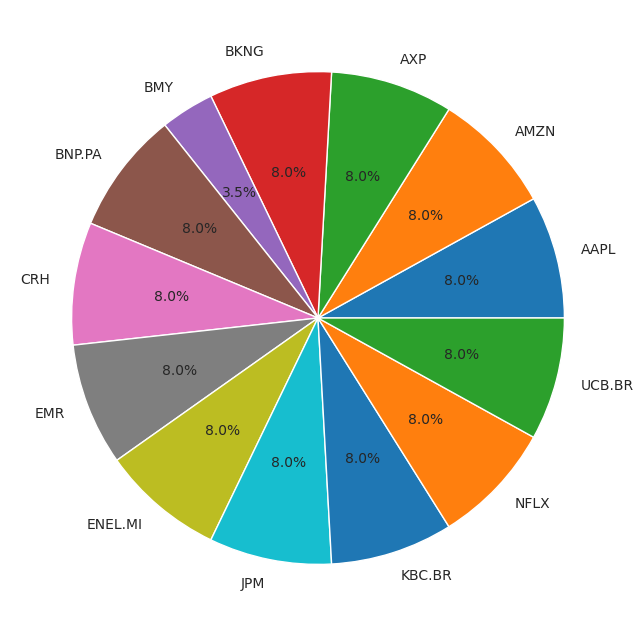

In [48]:
# @title Select accepted risk level { run: "auto" }
RiskMaxi = 2 # @param {type:"slider", min:0, max:25, step:1}
# MaxPctAlloc = 100 # @param {type:"integer"}
cv = EfficientCDaR(mu, historical_rets, beta=beta, weight_bounds=(0, MaxPctAlloc/100))
try:
    Orig_weights = cv.efficient_risk(RiskMaxi/100)
except:
    print("Sorry ... vous êtes trop gourmand!")
else:
    weights = {k:v for k,v in cv.clean_weights(cutoff=0.01).items() if v != 0}
    ret, risk = cv.portfolio_performance(verbose=True)

    labels = list(weights.keys())
    values = [j if j>=0 else 0 for j in list(weights.values())]

    sns.set_style("whitegrid")
    plt.figure(figsize=(8,8))
    plt.pie(values, labels=labels, autopct='%1.1f%%')
    #plt.title(f"Proposed allocation")
    plt.show()

In [49]:
# @title Manually change allocation
def handle_weights_change(change):
    values = [bBloc.value for bBloc in bBlocs]
    caption.value = (
        f'The slider {change.owner.description} has a value of {change.new}. '
        f'The values of all sliders are {values}'
    )

n_bBlocs = len(weights)
bBlocs = [
    widgets.FloatSlider(min=0, max=MaxPctAlloc/100, step=0.01, value=weights[labels[i]], description=f'{labels[i]}', orientation='vertical', disabled=False)
    for i in range(n_bBlocs)
]
for widget in bBlocs:
    widget.observe(handle_weights_change, names='value')
ui = widgets.HBox(bBlocs)
caption = widgets.Label(value='No change was made yet.')
display(caption, ui)


Label(value='No change was made yet.')

In [50]:
# @title Convert allocation in number of shares
availableCash = 321654 # @param {type:"number"}
#availableCash = 2000000
from pypfopt import DiscreteAllocation
da = DiscreteAllocation(cv.clean_weights(cutoff=0.01), prices.iloc[-1], total_portfolio_value=availableCash)
alloc, cashLeft = da.greedy_portfolio()
for k in alloc:
    print(f"{k:8s} : {alloc[k]:6d} shares")

print(f"Remaining cash : {cashLeft:7.2f}.")

AAPL     :    111 shares
AMZN     :    113 shares
AXP      :     82 shares
BKNG     :      5 shares
BNP.PA   :    408 shares
CRH      :    263 shares
EMR      :    206 shares
ENEL.MI  :   3802 shares
JPM      :     99 shares
KBC.BR   :    348 shares
NFLX     :     30 shares
UCB.BR   :    140 shares
BMY      :    200 shares
Remaining cash : 3489.92.
